In [1]:
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import os
import copy
from glob import glob
import cv2
import shutil
import time

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
def load_dataset(rel_path='.', mode="train", resize=False, resize_shape=(256, 256)):

    
    if os.path.exists(f"datasets_prep/{mode}/image.npy") and \
        os.path.exists(f"datasets_prep/{mode}/label.npy") and \
        os.path.exists(f"datasets_prep/{mode}/mask.npy"):
        
        new_input_tensor = np.load(f"datasets_prep/{mode}/image.npy")
        new_label_tensor = np.load(f"datasets_prep/{mode}/label.npy")
        new_mask_tensor = np.load(f"datasets_prep/{mode}/mask.npy")
        return new_input_tensor, new_label_tensor, new_mask_tensor
    
    train_image_files = sorted(glob(os.path.join(rel_path, f'data/{mode}/img_prep/*')))  #choose img
    train_label_files = sorted(glob(os.path.join(rel_path, f'data/{mode}/segm/*'))) #choose segm
    train_mask_files = sorted(glob(os.path.join(rel_path, f'data/{mode}/mask_prep/*'))) #choose mask
    
    for i, filename in enumerate(train_image_files):
        img = Image.open(filename)
        if resize:
            img = img.resize(resize_shape, Image.ANTIALIAS)
        imgmat = np.array(img).astype('float')
        imgmat = imgmat / 255.0
        if i == 0:
            input_tensor = np.expand_dims(imgmat, axis=0)
        else:
            tmp = np.expand_dims(imgmat, axis=0)
            input_tensor = np.concatenate((input_tensor, tmp), axis=0)
    new_input_tensor = np.moveaxis(input_tensor, 3, 1)
            
    for i, filename in enumerate(train_label_files):
        Img_label = Image.open(filename)
        if resize:
            Img_label = Img_label.resize(resize_shape, Image.ANTIALIAS)
            Img_label = Img_label.convert('1')
        label = np.array(Img_label)
        label = label / 1.0
        if i == 0:
            label_tensor = np.expand_dims(label, axis=0)
        else:
            tmp = np.expand_dims(label, axis=0)
            label_tensor = np.concatenate((label_tensor, tmp), axis=0)
    new_label_tensor = np.stack((label_tensor[:,:,:], 1 - label_tensor[:,:,:]), axis=1)
    
    for i, filename in enumerate(train_mask_files):
        Img_mask = Image.open(filename)
        if resize:
            Img_mask = Img_mask.resize(resize_shape, Image.ANTIALIAS)
            Img_mask = Img_mask.convert('1')
        mask = np.array(Img_mask)
        mask = mask / 1.0
        if i == 0:
            mask_tensor = np.expand_dims(mask, axis=0)
        else:
            tmp = np.expand_dims(mask, axis=0)
            mask_tensor = np.concatenate((mask_tensor, tmp), axis=0)
    new_mask_tensor = np.stack((mask_tensor[:,:,:], mask_tensor[:,:,:]), axis=1)
    
    if not os.path.exists("./datasets_prep"):
        os.mkdir("./datasets_prep")
    if not os.path.exists(f"./datasets_prep/{mode}"):
        os.mkdir(f"./datasets_prep/{mode}")
    np.save(f"datasets_prep/{mode}/image.npy", new_input_tensor)
    np.save(f"datasets_prep/{mode}/label.npy", new_label_tensor)
    np.save(f"datasets_prep/{mode}/mask.npy", new_mask_tensor)
    
    return new_input_tensor, new_label_tensor, new_mask_tensor

In [3]:
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(ConvBNReLU, self).__init__()
        self.convbnrelu = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )          
    def forward(self, x):
        return self.convbnrelu(x)
    

class ConvNoPool(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(ConvNoPool, self).__init__()
        self.convnopool = nn.Sequential(
            ConvBNReLU(in_ch, out_ch),
            ConvBNReLU(out_ch, out_ch)
        )        
    def forward(self, x):
        return self.convnopool(x)

    
class ConvPool(nn.Module):

    def __init__(self, in_ch, out_ch):
        super(ConvPool, self).__init__()
        self.convpool = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            ConvBNReLU(in_ch, out_ch),
            ConvBNReLU(out_ch, out_ch)
        )
    def forward(self, x):
        return self.convpool(x)
    
class UpsampleConv(nn.Module):
    def __init__(self, in_ch, out_ch, isDeconv=True):
        super(UpsampleConv, self).__init__()
        if isDeconv:
            self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        else:
            self.up = nn.Sequential(
                nn.UpsamplingBilinear2d(scale_factor=2),
                nn.Conv2d(in_ch, out_ch, kernel_size=1)
            )
        self.convtwice = nn.Sequential(
            ConvBNReLU(in_ch, out_ch),
            ConvBNReLU(out_ch, out_ch)
        )
            
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x2.size()[3] - x1.size()[3]
        diffY = x2.size()[2] - x1.size()[2]
        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        x = torch.cat([x2, x1], dim=1)
        x = self.convtwice(x)
        return x

class ConvOut(nn.Module):
    def __init__(self, in_ch):
        super(ConvOut, self).__init__()
        self.convout = nn.Sequential(
            nn.Conv2d(in_ch, in_ch, kernel_size=1),
            nn.Conv2d(in_ch, in_ch, kernel_size=1),
            nn.Conv2d(in_ch, 1, kernel_size=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        output_ = self.convout(x)
        return output_
    
class Unet(nn.Module):
    def __init__(self, img_ch, fch_base=16, isDeconv=True):
        super(Unet, self).__init__()
        
        self.blocks = nn.ModuleList()
        
        self.down1 = ConvNoPool(img_ch, fch_base)
        self.down2 = ConvPool(fch_base, fch_base * 2)
        self.down3 = ConvPool(fch_base * 2, fch_base * 4)
        self.down4 = ConvPool(fch_base * 4, fch_base * 8)
        
        self.encoder = ConvPool(fch_base * 8, fch_base * 16)
        
        self.up1 = UpsampleConv(fch_base * 16 , fch_base * 8, isDeconv)
        self.up2 = UpsampleConv(fch_base * 8, fch_base * 4, isDeconv)
        self.up3 = UpsampleConv(fch_base * 4, fch_base * 2 , isDeconv)
        self.up4 = UpsampleConv(fch_base * 2, fch_base, isDeconv)
        
        self.out = ConvOut(fch_base)
        
        self.blocks = nn.ModuleList([self.down1, self.down2, self.down3,\
                                     self.down4, self.encoder, self.up1, self.up2,\
                                     self.up3, self.up4, self.out])

    def forward(self, input_):
        d1 = self.down1(input_)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        enc = self.encoder(d4)
        u1 = self.up1(enc, d4)
        u2 = self.up2(u1, d3)
        u3 = self.up3(u2, d2)
        u4 = self.up4(u3, d1)
        output_ = self.out(u4)
        return output_

In [4]:
from sklearn.metrics import roc_auc_score

def eval_print_metrics(bat_label, bat_pred, bat_mask):
    assert len(bat_label.size()) == 4 and len(bat_pred.size()) == 4
    assert bat_label.size()[1] == 1 and bat_pred.size()[1] == 1
    
    masked_pred = bat_pred * bat_mask
    masked_label = bat_label * bat_mask
    masked_pred_class = (masked_pred > 0.35).float()
    
    precision = float(torch.sum(masked_pred_class * masked_label)) / (float(torch.sum(masked_pred_class)) + 1)
    recall = float(torch.sum(masked_pred_class * masked_label)) / (float(torch.sum(masked_label.float())) + 1)
    f1_score = 2.0 * precision * recall / (precision + recall + 1e-8)
    
    pred_ls = bat_pred.detach().numpy()
    label_ls = np.array(bat_label.detach(), dtype=int)

    pred_ls = np.array(bat_pred[bat_mask > 0].detach())
    label_ls = np.array(bat_label[bat_mask > 0].detach(), dtype=int)
    try:
        bat_auc = roc_auc_score(label_ls, pred_ls)
    except ValueError:
        bat_auc = 0

    print("precision: {:.4f} recall: {:.4f} f1_score: {:.4f} auc: {:.4f}".format(precision, recall, f1_score, bat_auc))

    return precision, recall, f1_score, bat_auc

def paste_and_save(bat_img, bat_label, bat_pred_class, batch_size, cur_bat_num, save_img='pred_imgs_prep'):
    w, h = bat_img.size()[2:4]
    for bat_id in range(bat_img.size()[0]):
        img = Image.fromarray(np.moveaxis(np.array(bat_img * 255.0, dtype=np.uint8)[bat_id, :, :, :], 0, 2))
        label = Image.fromarray(np.array(bat_label * 255.0, dtype=np.uint8)[bat_id, 0, :, :])
        pred_class = Image.fromarray(np.array(bat_pred_class * 255.0, dtype=np.uint8)[bat_id, 0, :, :])
        
        res_id = (cur_bat_num - 1) * batch_size + bat_id
        target = Image.new('RGB', (3 * w, h))
        target.paste(img, box = (0, 0))
        target.paste(label, box = (w, 0))
        target.paste(pred_class, box = (2 * w, 0))
        
        target.save(os.path.join(save_img, "result_{}.png".format(res_id)))
    return target


In [5]:
def dice_loss(pred, target, smooth=1.):
    """Dice loss
    """
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()

In [6]:
# set parameters for training
EPOCHS = 50
BATCH_SIZE = 8

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

unet_ins = Unet(img_ch=3, isDeconv=True)
unet_ins.to(device)

criterion = nn.BCELoss()
# cirterion = dice_loss(pred, target, smooth=1.)
# criterion =  torch.nn.functional.binary_cross_entropy(inputs, targets, reduction='mean')

optimizer = torch.optim.SGD(unet_ins.parameters(), lr=0.1)

In [9]:
import warnings
warnings.filterwarnings('ignore')

def model_train(net, optimizer, criterion, epochs=50, batch_size=2):
    since = time.time()
    train_loss_list = []
    train_prec_list = []
    valid_loss_list = []
    valid_prec_list = []
    
    best_model_wts = copy.deepcopy(net.state_dict())
    best_epoch_avg_loss = float('inf')
    
    for epoch in range(epochs):
        epoch_tot_loss = 0
        print(f'Epoch [{epoch + 1}/{epochs}]')
        for phase in ['train', 'val']:
            
            if phase == 'train':
                net.train()  
            else:
                net.eval()
            
            x_tensor, y_tensor, m_tensor = load_dataset(mode=phase, resize=True, resize_shape=(256, 256))
    
            num_samples = x_tensor.shape[0]
        
            num_iters = int(np.ceil(num_samples / batch_size))
            shuffle_ids = np.random.permutation(num_samples)
            x_tensor = x_tensor[shuffle_ids, :, :, :]
            y_tensor = y_tensor[shuffle_ids, :, :, :]

            for ite in range(num_iters):
                if not ite == num_iters - 1:
                    start_id, end_id = ite * batch_size, (ite + 1) * batch_size
                    bat_img = torch.Tensor(x_tensor[start_id : end_id, :, :, :])
                    bat_label = torch.Tensor(y_tensor[start_id : end_id, 0: 1, :, :])
                    bat_mask = torch.Tensor(m_tensor[start_id : end_id, 0: 1, :, :])
                else:
                    start_id = ite * batch_size
                    bat_img = torch.Tensor(x_tensor[start_id : , :, :, :])
                    bat_label = torch.Tensor(y_tensor[start_id : , 0: 1, :, :])
                    bat_mask = torch.Tensor(m_tensor[start_id : , 0: 1, :, :])

                optimizer.zero_grad()
                
                bat_img = bat_img.to(device)
                bat_label = bat_label.to(device)
                
                with torch.set_grad_enabled(phase == 'train'):
                    bat_pred = net(bat_img)
                    loss = criterion(bat_pred, bat_label.float())
                    # masked_pred = bat_pred * bat_mask
                    # masked_label = bat_label * bat_mask
                    # loss = criterion(masked_pred, masked_label.float(), reduction='mean')

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()                     

                if not ite == num_iters - 1:
                    epoch_tot_loss += loss.item()
                else:
                    epoch_tot_loss += loss.item()
                    epoch_avg_loss = epoch_tot_loss / (ite + 1)
                    plint = phase if phase == 'train' else 'valid'
                    print("{} avg_loss : {:.4f} ".format(plint, epoch_avg_loss), end = '')
                    prec, _, _, _ = eval_print_metrics(bat_label.to('cpu'), bat_pred.to('cpu'), bat_mask)
             
            if phase == 'train':
                train_loss_list.append(epoch_avg_loss)
                train_prec_list.append(prec)
            else:
                valid_loss_list.append(epoch_avg_loss)
                valid_prec_list.append(prec)
                
            if phase == 'val' and epoch_avg_loss < best_epoch_avg_loss:
                best_epoch_avg_loss = epoch_avg_loss
                best_model_wts = copy.deepcopy(net.state_dict())
                
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best validation loss: {best_epoch_avg_loss:4f}')
    xepoch = np.arange(epochs, dtype=int)+1
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, layout="constrained")
    
    ax1.plot(xepoch, train_loss_list, label='train')
    ax1.plot(xepoch, valid_loss_list, label='valid')
    ax1.legend(loc="center right")
    ax1.set_ylabel('loss')
    
    ax2.plot(xepoch, train_prec_list, label='train')
    ax2.plot(xepoch, valid_prec_list, label='valid')
    ax2.legend(loc="center right")
    ax2.set_ylabel('precistion')
    plt.plot()
    
    net.load_state_dict(best_model_wts)
    return net


Epoch [1/10]
train avg_loss : 0.1583 precision: 0.7439 recall: 0.6238 f1_score: 0.6786 auc: 0.9495
valid avg_loss : 0.7709 precision: 0.2352 recall: 0.8007 f1_score: 0.3636 auc: 0.8980
Epoch [2/10]
train avg_loss : 0.1488 precision: 0.6859 recall: 0.6213 f1_score: 0.6520 auc: 0.9440
valid avg_loss : 0.6511 precision: 0.7704 recall: 0.6637 f1_score: 0.7131 auc: 0.9567
Epoch [3/10]
train avg_loss : 0.1422 precision: 0.6964 recall: 0.6708 f1_score: 0.6833 auc: 0.9505
valid avg_loss : 0.6301 precision: 0.6308 recall: 0.6981 f1_score: 0.6628 auc: 0.9432
Epoch [4/10]
train avg_loss : 0.1377 precision: 0.6723 recall: 0.6947 f1_score: 0.6833 auc: 0.9591
valid avg_loss : 0.6278 precision: 0.5733 recall: 0.8546 f1_score: 0.6862 auc: 0.9671
Epoch [5/10]
train avg_loss : 0.1342 precision: 0.4963 recall: 0.4694 f1_score: 0.4825 auc: 0.8207
valid avg_loss : 0.5965 precision: 0.8148 recall: 0.5980 f1_score: 0.6897 auc: 0.9455
Epoch [6/10]
train avg_loss : 0.1313 precision: 0.4572 recall: 0.4440 f1_sc

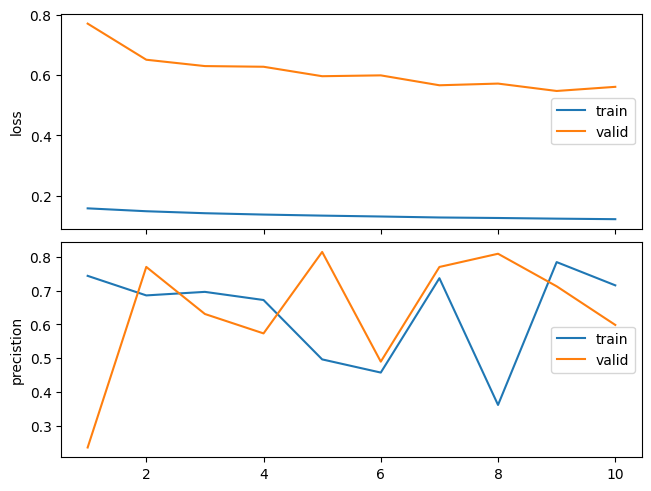

In [10]:
trained_unet = model_train(unet_ins, optimizer, criterion, batch_size=BATCH_SIZE, epochs=10)

In [11]:
def model_test(net, batch_size=2):
    
    prec_cul = 0
    rec_cul = 0
    f1_cul = 0
    auc_cul = 0
    
    x_tensor, y_tensor, m_tensor = load_dataset(mode='test', resize=True, resize_shape=(256, 256))
    num_samples = x_tensor.shape[0]
    num_iters = int(np.ceil(num_samples / batch_size))
    for ite in range(num_iters):
        print("predicting on the {}th batch".format(ite + 1))
        if not ite == num_iters - 1:
            start_id, end_id = ite * batch_size, (ite + 1) * batch_size
            bat_img = torch.Tensor(x_tensor[start_id : end_id, :, :, :])
            bat_label = torch.Tensor(y_tensor[start_id : end_id, 0: 1, :, :])
            bat_mask = torch.Tensor(m_tensor[start_id : end_id, 0: 1, :, :])
        else:
            start_id = ite * batch_size
            bat_img = torch.Tensor(x_tensor[start_id : , :, :, :])
            bat_label = torch.Tensor(y_tensor[start_id : , 0: 1, :, :])
            bat_mask = torch.Tensor(m_tensor[start_id : , 0: 1, :, :])
            
        bat_pred = net(bat_img.to(device))
        bat_pred = bat_pred.to('cpu')
        bat_pred_class = (bat_pred > 0.35).float() * bat_mask
        
        prec, rec, f1, auc = eval_print_metrics(bat_label, bat_pred, bat_mask)
        prec_cul += prec
        rec_cul += rec
        f1_cul += f1
        auc_cul += auc
        aa = paste_and_save(bat_img, bat_label, bat_pred_class, batch_size, ite + 1)
        plt.imshow(aa)
        plt.title('last image in batch')
        plt.axis('off')
        plt.show()
    print("Testing average\nprecision: {:.2f} % recall: {:.2f} % f1_score: {:.4f} auc: {:.4f}".format(100*prec_cul/num_iters, 100*rec_cul/num_iters, f1_cul/num_iters, auc_cul/num_iters))

    return

if os.path.exists("./pred_imgs_prep"):
    shutil.rmtree("./pred_imgs_prep")
os.mkdir("./pred_imgs_prep")


predicting on the 1th batch
precision: 0.6167 recall: 0.5777 f1_score: 0.5965 auc: 0.9296


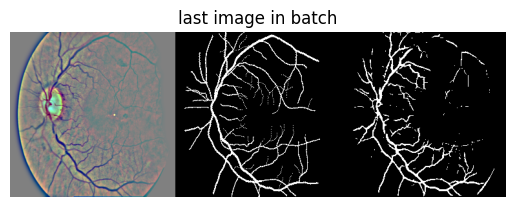

predicting on the 2th batch
precision: 0.6523 recall: 0.7684 f1_score: 0.7056 auc: 0.9494


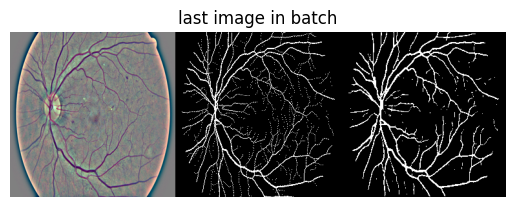

predicting on the 3th batch
precision: 0.7302 recall: 0.7149 f1_score: 0.7225 auc: 0.9408


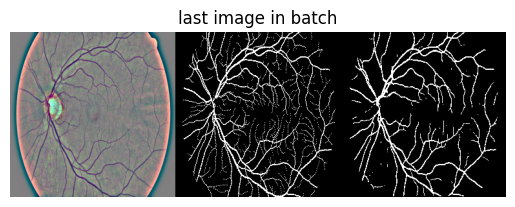

predicting on the 4th batch
precision: 0.7175 recall: 0.7287 f1_score: 0.7231 auc: 0.9438


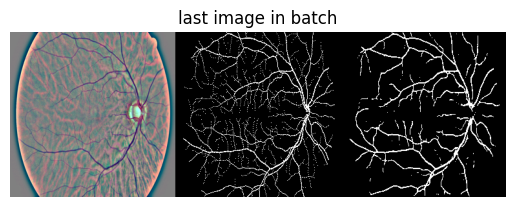

predicting on the 5th batch
precision: 0.5893 recall: 0.6075 f1_score: 0.5983 auc: 0.9199


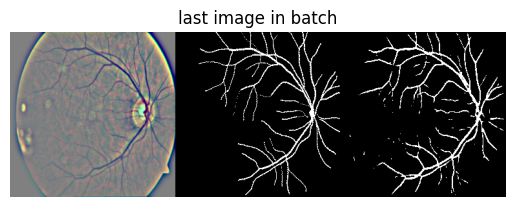

predicting on the 6th batch
precision: 0.7148 recall: 0.6527 f1_score: 0.6823 auc: 0.9431


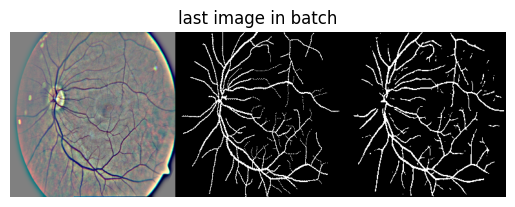

predicting on the 7th batch
precision: 0.6985 recall: 0.7104 f1_score: 0.7044 auc: 0.9490


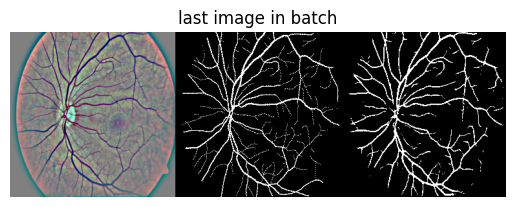

predicting on the 8th batch
precision: 0.7127 recall: 0.6761 f1_score: 0.6939 auc: 0.9533


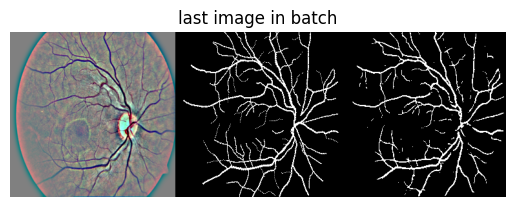

predicting on the 9th batch
precision: 0.7460 recall: 0.6793 f1_score: 0.7111 auc: 0.9517


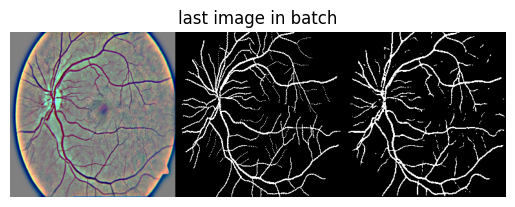

predicting on the 10th batch
precision: 0.6746 recall: 0.7296 f1_score: 0.7010 auc: 0.9578


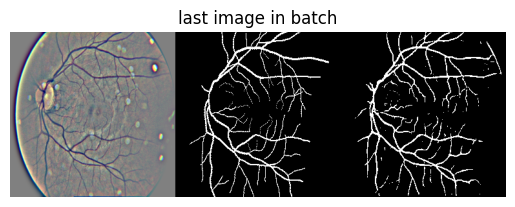

predicting on the 11th batch
precision: 0.6604 recall: 0.6942 f1_score: 0.6769 auc: 0.9512


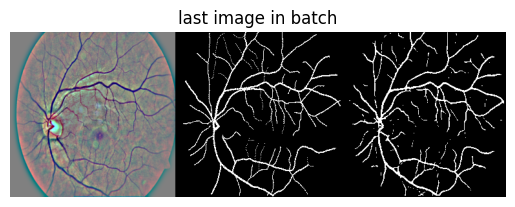

predicting on the 12th batch
precision: 0.3913 recall: 0.3820 f1_score: 0.3866 auc: 0.7589


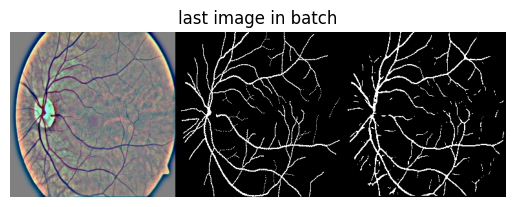

predicting on the 13th batch
precision: 0.3338 recall: 0.3364 f1_score: 0.3351 auc: 0.7429


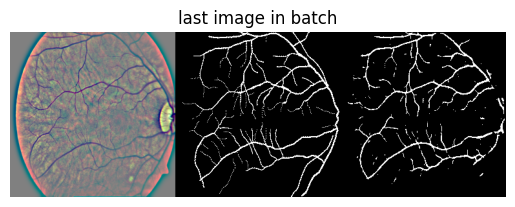

predicting on the 14th batch
precision: 0.6479 recall: 0.6199 f1_score: 0.6336 auc: 0.9405


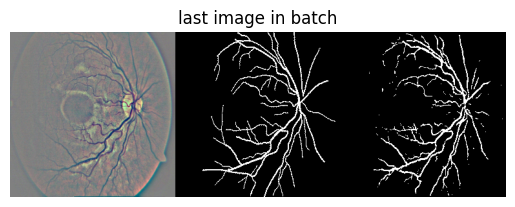

predicting on the 15th batch
precision: 0.5550 recall: 0.6082 f1_score: 0.5804 auc: 0.9254


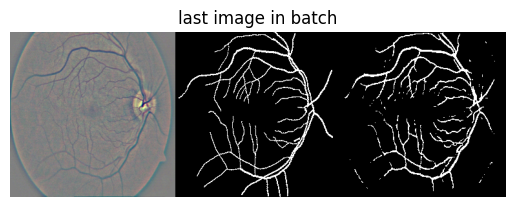

predicting on the 16th batch
precision: 0.6955 recall: 0.7078 f1_score: 0.7016 auc: 0.9528


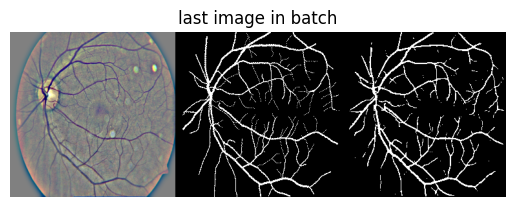

predicting on the 17th batch
precision: 0.7618 recall: 0.6950 f1_score: 0.7269 auc: 0.9594


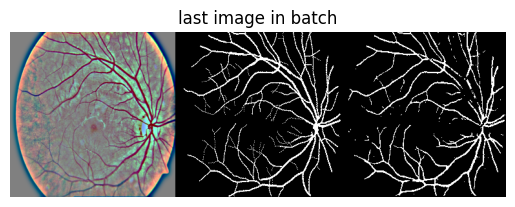

predicting on the 18th batch
precision: 0.5956 recall: 0.6669 f1_score: 0.6292 auc: 0.9362


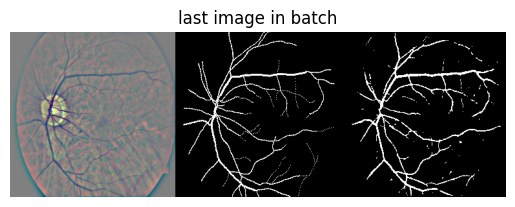

predicting on the 19th batch
precision: 0.5484 recall: 0.6242 f1_score: 0.5838 auc: 0.9440


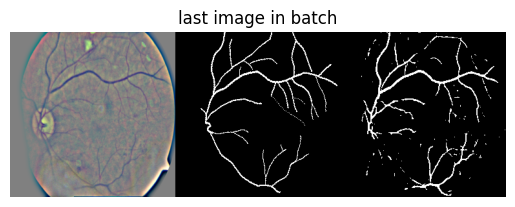

predicting on the 20th batch
precision: 0.6196 recall: 0.4818 f1_score: 0.5421 auc: 0.8127


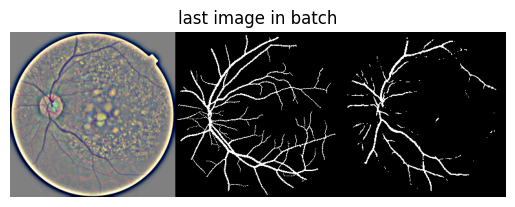

predicting on the 21th batch
precision: 0.4987 recall: 0.4037 f1_score: 0.4462 auc: 0.7825


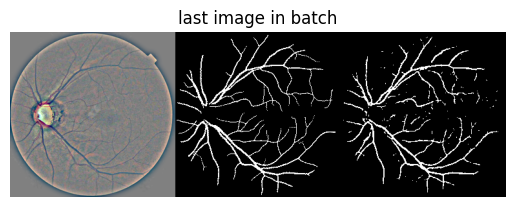

predicting on the 22th batch
precision: 0.1367 recall: 0.1439 f1_score: 0.1402 auc: 0.6252


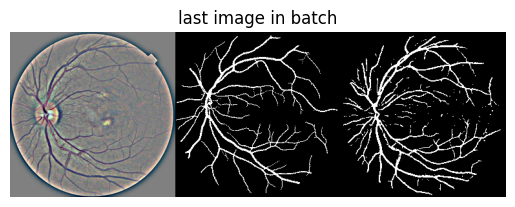

predicting on the 23th batch
precision: 0.1075 recall: 0.0719 f1_score: 0.0862 auc: 0.5696


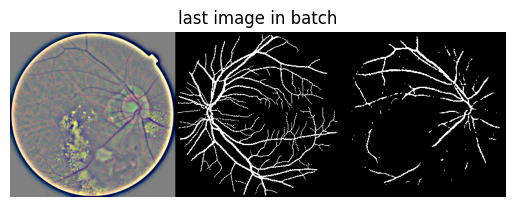

predicting on the 24th batch
precision: 0.4892 recall: 0.3840 f1_score: 0.4303 auc: 0.7958


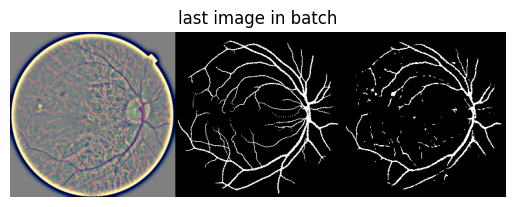

predicting on the 25th batch
precision: 0.8609 recall: 0.7148 f1_score: 0.7811 auc: 0.9654


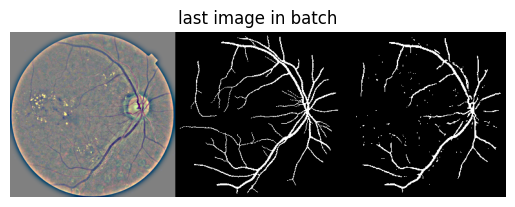

predicting on the 26th batch
precision: 0.8363 recall: 0.7762 f1_score: 0.8052 auc: 0.9797


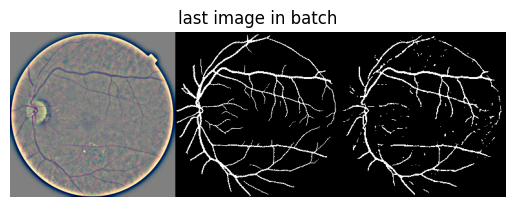

predicting on the 27th batch
precision: 0.8672 recall: 0.7641 f1_score: 0.8124 auc: 0.9767


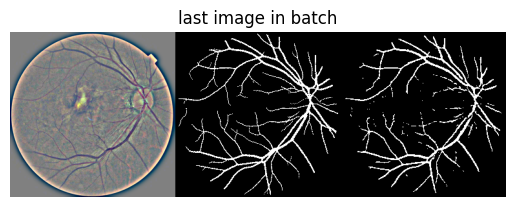

predicting on the 28th batch
precision: 0.8805 recall: 0.6462 f1_score: 0.7454 auc: 0.9744


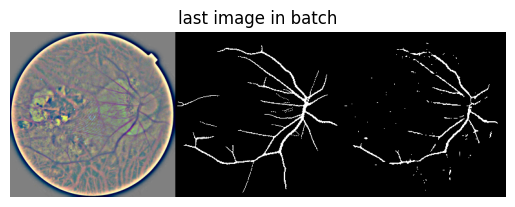

predicting on the 29th batch
precision: 0.8606 recall: 0.7652 f1_score: 0.8101 auc: 0.9764


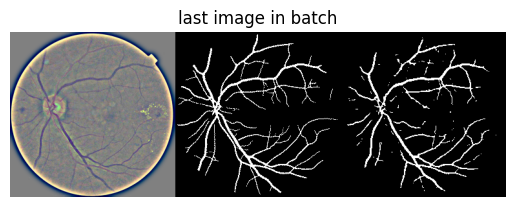

predicting on the 30th batch
precision: 0.8567 recall: 0.7280 f1_score: 0.7871 auc: 0.9687


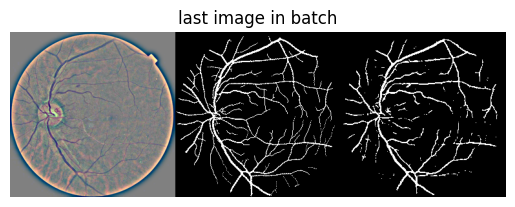

predicting on the 31th batch
precision: 0.8537 recall: 0.7502 f1_score: 0.7986 auc: 0.9746


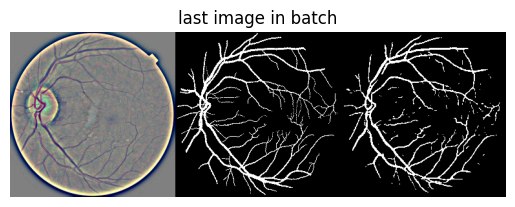

predicting on the 32th batch
precision: 0.4857 recall: 0.4087 f1_score: 0.4439 auc: 0.7739


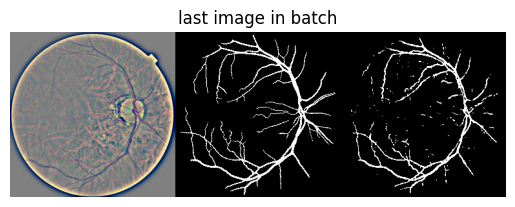

predicting on the 33th batch
precision: 0.8295 recall: 0.7203 f1_score: 0.7710 auc: 0.9733


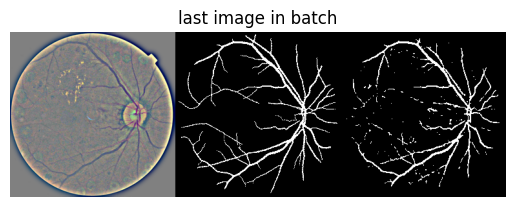

predicting on the 34th batch
precision: 0.8402 recall: 0.7538 f1_score: 0.7947 auc: 0.9732


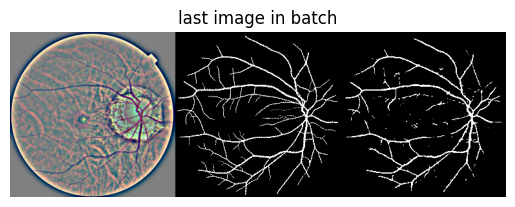

predicting on the 35th batch
precision: 0.8381 recall: 0.7516 f1_score: 0.7925 auc: 0.9774


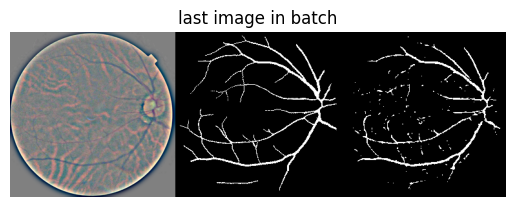

predicting on the 36th batch
precision: 0.7114 recall: 0.6575 f1_score: 0.6834 auc: 0.9601


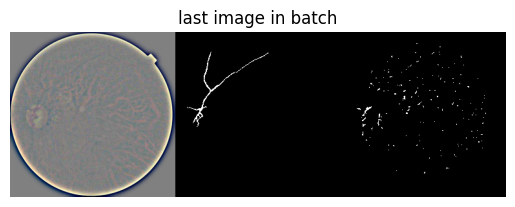

predicting on the 37th batch
precision: 0.8499 recall: 0.5881 f1_score: 0.6952 auc: 0.9519


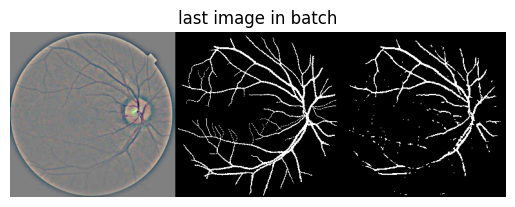

predicting on the 38th batch
precision: 0.8090 recall: 0.7706 f1_score: 0.7893 auc: 0.9811


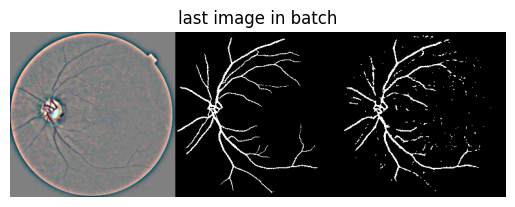

predicting on the 39th batch
precision: 0.7823 recall: 0.7511 f1_score: 0.7663 auc: 0.9674


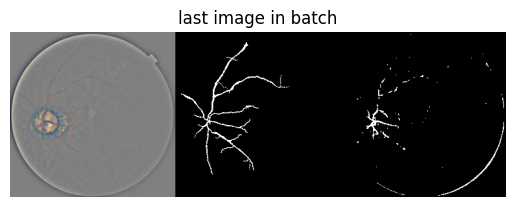

predicting on the 40th batch
precision: 0.8128 recall: 0.7199 f1_score: 0.7635 auc: 0.9651


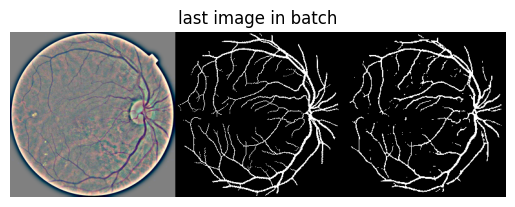

predicting on the 41th batch
precision: 0.8100 recall: 0.7644 f1_score: 0.7866 auc: 0.9764


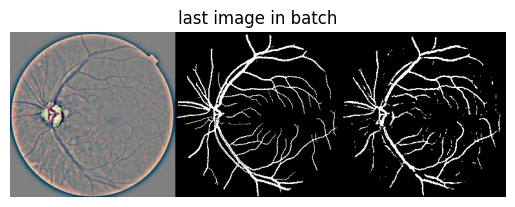

predicting on the 42th batch
precision: 0.8177 recall: 0.6529 f1_score: 0.7261 auc: 0.9589


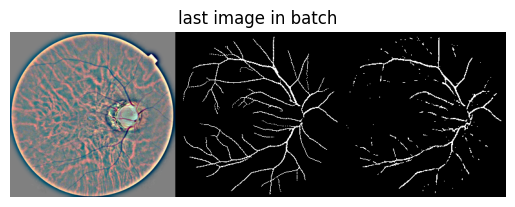

predicting on the 43th batch
precision: 0.7983 recall: 0.4443 f1_score: 0.5709 auc: 0.8989


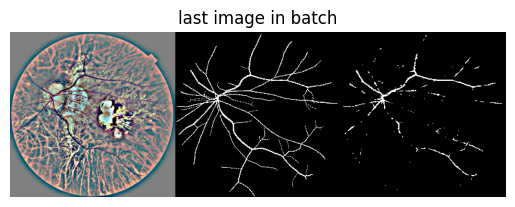

predicting on the 44th batch
precision: 0.8184 recall: 0.6962 f1_score: 0.7524 auc: 0.9673


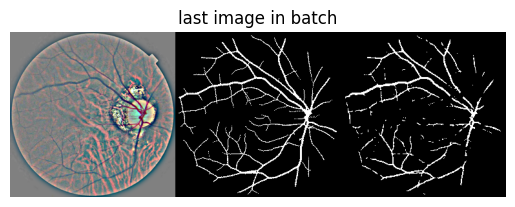

predicting on the 45th batch
precision: 0.8281 recall: 0.6663 f1_score: 0.7385 auc: 0.9692


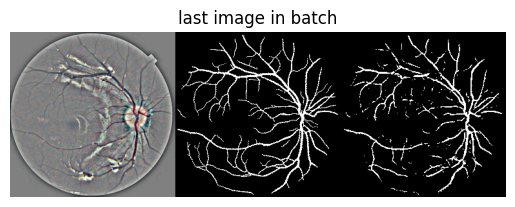

predicting on the 46th batch
precision: 0.8625 recall: 0.7839 f1_score: 0.8213 auc: 0.9749


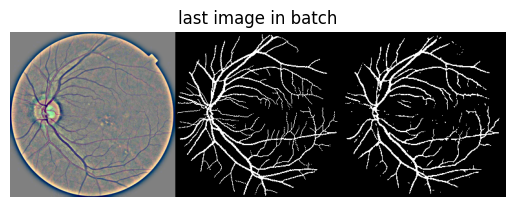

predicting on the 47th batch
precision: 0.8656 recall: 0.7848 f1_score: 0.8232 auc: 0.9820


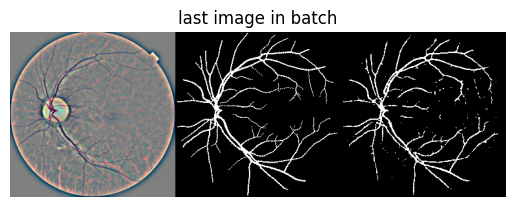

predicting on the 48th batch
precision: 0.8514 recall: 0.8212 f1_score: 0.8360 auc: 0.9829


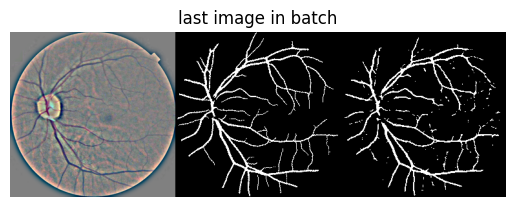

predicting on the 49th batch
precision: 0.8545 recall: 0.8183 f1_score: 0.8360 auc: 0.9844


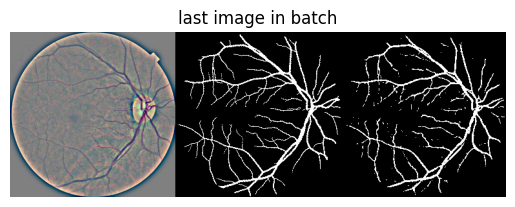

predicting on the 50th batch
precision: 0.8670 recall: 0.7577 f1_score: 0.8087 auc: 0.9803


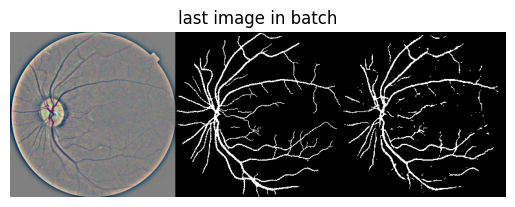

predicting on the 51th batch
precision: 0.8385 recall: 0.8118 f1_score: 0.8250 auc: 0.9822


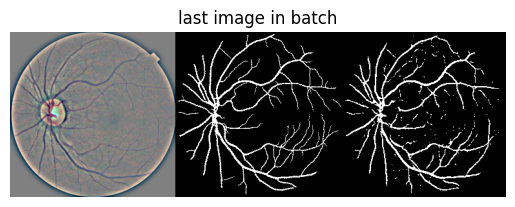

predicting on the 52th batch
precision: 0.8328 recall: 0.7222 f1_score: 0.7735 auc: 0.9721


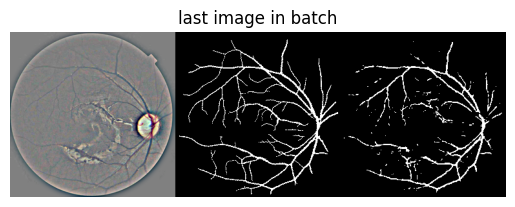

predicting on the 53th batch
precision: 0.8401 recall: 0.8248 f1_score: 0.8324 auc: 0.9815


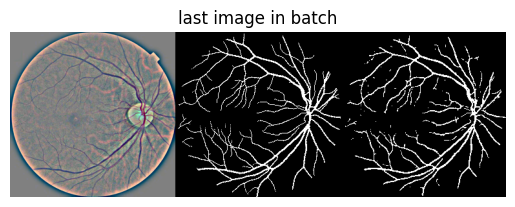

predicting on the 54th batch
precision: 0.8667 recall: 0.7936 f1_score: 0.8286 auc: 0.9797


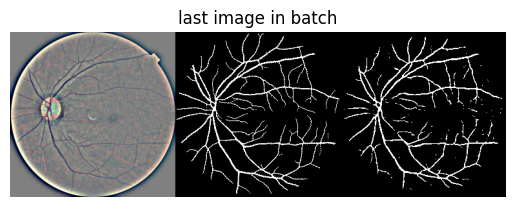

predicting on the 55th batch
precision: 0.8529 recall: 0.6697 f1_score: 0.7503 auc: 0.9644


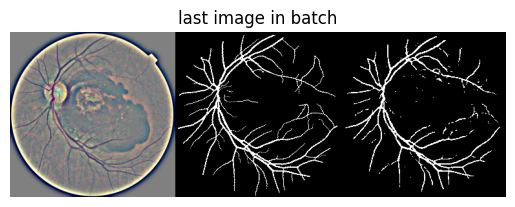

predicting on the 56th batch
precision: 0.8859 recall: 0.6771 f1_score: 0.7676 auc: 0.9720


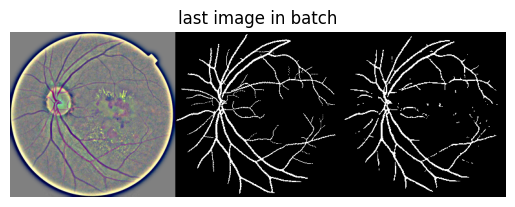

predicting on the 57th batch
precision: 0.8098 recall: 0.5696 f1_score: 0.6688 auc: 0.9397


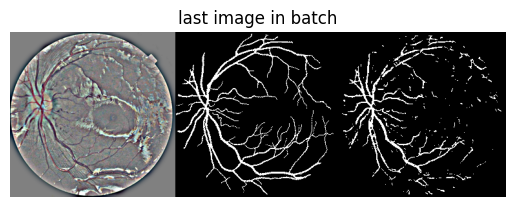

predicting on the 58th batch
precision: 0.8726 recall: 0.7311 f1_score: 0.7956 auc: 0.9742


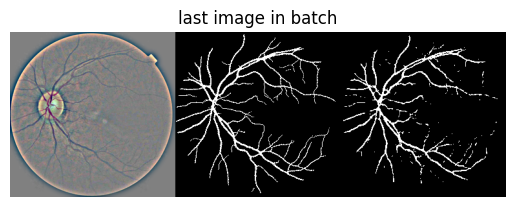

Testing average
precision: 72.49 % recall: 65.38 % f1_score: 0.6848 auc: 0.9296


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
a = model_test(trained_unet, batch_size=2)
shutil.rmtree('./datasets_prep')

In [13]:
# torch.save(trained_unet.state_dict(), 'models/unet_100epochs_data_prep.pt')

# model_ft = model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
# num_ftrs = model_ft.classifier.in_features
# model_ft.classifier  = nn.Linear(num_ftrs, len(class_names))
# model_ft.load_state_dict(torch.load('models/dens_4b_24e_17m.pt'))

torch.cuda.empty_cache()